In [1]:
import numpy as np
from scipy.spatial import distance_matrix
from sklearn.metrics import pairwise_distances
from sklearn.decomposition import PCA, KernelPCA
from skimage import color 
from scipy.ndimage import gaussian_filter
import matplotlib.pyplot as plt
from skimage import io
from tqdm import tqdm

# Exercice 1

tirez 100 vecteurs aléatoires $v_i$ de taille $D$ avec $D$ qui va $1$ à $1000$ et pour chaque valeur de $D$ calculer $y(D)= \frac{\max_{i,j}( \| v_i - v_j\|^2)}{\min_{i,j}( \| v_i - v_j\|^2)}$.
représentez la courbe $y(D)$.

In [2]:
y = np.zeros((1000))
for D in np.arange(1,1001):
    v = np.random.rand(3, D)
    distances = pairwise_distances(v)**2
    distances = distances[distances!=0]
    y[D-1]    = np.max(distances)/np.min(distances)

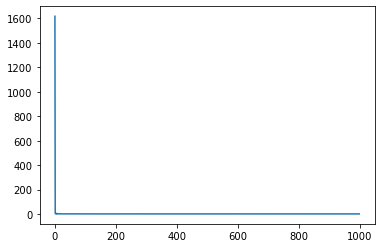

In [3]:
plt.plot(y)
plt.show()

# Exercice 2

tirez 1000 vecteurs aléatoires $v_i$ de $\mathbb{R}^3$ dans une boule rayon $5$. Réduire la dimension de cette boule pour passer à $\mathbb{R}^2$ avec l'ACP et la kernel ACP avec différent kernels.

In [4]:
cnt = 0
v = np.zeros((1000,3))
while cnt < 1000:
    v[cnt,:] = 10 * np.random.rand(1,3) - 5
    if np.linalg.norm(v[cnt,:]) <= 5:
        cnt += 1

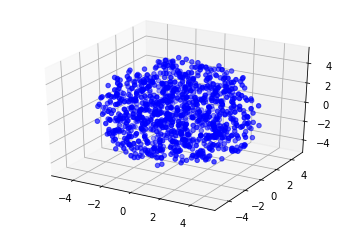

In [5]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(v[:,0], v[:,1], v[:,2], c='b', marker='o')
plt.show()

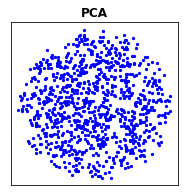

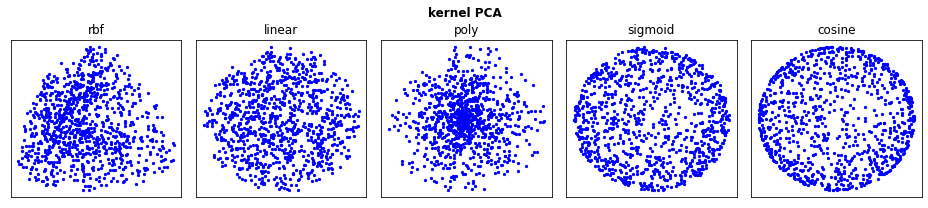

In [6]:
kernels = ["rbf","linear","poly","sigmoid","cosine"]
plt.figure(figsize=(3,3))
pca   = PCA()
v_pca = pca.fit_transform(v)
plt.scatter(v_pca[:, 0], v_pca[:, 1], c='b', marker='o', s=5)
plt.xticks(()), plt.yticks(())
plt.title("PCA",fontweight="bold")
plt.show()

kernels = ["rbf","linear","poly","sigmoid","cosine"]
plt.figure(figsize=(13,3))
for i,k in enumerate(kernels):
    kpca   = KernelPCA(kernel=k)
    v_kpca = kpca.fit_transform(v)
    plt.subplot(1,5,i+1)
    plt.scatter(v_kpca[:, 0], v_kpca[:, 1], c='b', marker='o', s=5)
    plt.xticks(()), plt.yticks(())
    plt.title(k)
    
plt.tight_layout(rect=[0, 0.03, 1, 0.95]) 
plt.suptitle("kernel PCA",fontweight="bold")
plt.show()


# Exercice 3

Calculer les points de clef Harris dans les images lego et chessboard. Je veux que vous écriviez le code.

In [7]:
def findCorners(img, window_size, k, thresh, display=False):
    """
    inputs :
        - img         : The original image                              < m x n > - float
        - window_size : The size (side length) of the sliding window    < 1 >     - int
        - k           : Harris corner constant. Usually 0.04 - 0.06     < 1 >     - int
        - thresh      : The threshold above which a corner is counted   < 1 >     - int
        - display     : boolean to display R responses values           < 1 >     - bool
    outputs :
        - final_corners : list of key Harris key point                  < p x 2 > - int
    """
    # Find x and y derivatives
    dy, dx = np.gradient(color.rgb2gray(img)) # do centered finite differences as a sobel operator
    Ixx    = gaussian_filter(dx**2, sigma=1)
    Ixy    = gaussian_filter(dy*dx, sigma=1)
    Iyy    = gaussian_filter(dy**2, sigma=1)
    height = img.shape[0]
    width  = img.shape[1]

    offset      = window_size // 2
    corner_img  = img.copy()
    r_list      = [] # list of all R responses
    corner_list = [] # corner list before non-maxima suppression
    # Loop through image (crop according to window size)
    for y in tqdm(range(offset, height - offset)):
        for x in range(offset, width - offset):
            
            # Calculate sum of squares
            Ixx_window = Ixx[y - offset:y + offset + 1, x - offset:x + offset + 1]
            Ixy_window = Ixy[y - offset:y + offset + 1, x - offset:x + offset + 1]
            Iyy_window = Iyy[y - offset:y + offset + 1, x - offset:x + offset + 1]
            Sxx = Ixx_window.sum()
            Sxy = Ixy_window.sum()
            Syy = Iyy_window.sum()
            # Find determinant and trace, use to get corner response
            det   = (Sxx * Syy) - (Sxy**2)
            trace = Sxx + Syy
            r     = det - k * (trace**2)
            r_list.append(r)
            # If corner response is over threshold, add to corner list
            if r > thresh:
                corner_list.append([x, y, r])
                
    # non-maxima suppression
    corner_list   = np.array(corner_list)
    final_corners = []
    cnt = 0
    while cnt < len(corner_list):
        mask_x      = (corner_list[cnt,0] - window_size < corner_list[:,0]) & (corner_list[:,0] < corner_list[cnt,0] + window_size)
        mask_y      = (corner_list[cnt,1] - window_size < corner_list[:,1]) & (corner_list[:,1] < corner_list[cnt,1] + window_size)
        corner_mask = corner_list[mask_x & mask_y,:]
        arg_max     = np.argmax(corner_mask[:,2])
        final_corners.append(corner_mask[arg_max,:])
        cnt += len(corner_mask)
        
    if display:
        plt.figure(figsize=(10,6))
        plt.show()
        plt.plot(r_list)
        plt.title("R responses")
        plt.show()
        
    return final_corners

## Lego

In [8]:
image = io.imread("lego.jpg")

100%|████████████████████████████████████████████████████████████████████████████████| 527/527 [00:07<00:00, 68.84it/s]


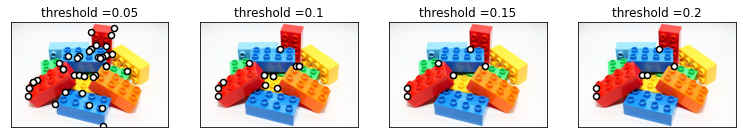

In [9]:
window_size       = 7
k_corner_response = 0.04
plt.figure(figsize=(13,4))
for i,corner_threshold in enumerate([0.05,0.1,0.15,0.2]):
    corner_list  = findCorners(image, window_size, k_corner_response, corner_threshold)
    corner_array = np.array(corner_list).astype(int)
    plt.subplot(1,4,i+1)
    plt.imshow(image)
    plt.plot(corner_array[:,0], corner_array[:,1], 'o', markerfacecolor='w', markeredgewidth=1.5, markeredgecolor='k')
    plt.title("threshold =" + str(corner_threshold))
    plt.xticks(()), plt.yticks(())
plt.show()

## Chessboard

In [10]:
image = color.rgba2rgb(io.imread("chessboard.png"))

100%|██████████████████████████████████████████████████████████████████████████████| 3717/3717 [03:50<00:00, 16.13it/s]


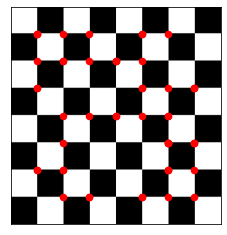

In [11]:
window_size       = 7
k_corner_response = 0.05
corner_threshold  = 1

corner_list = findCorners(image, window_size, k_corner_response, corner_threshold)
corner_array = np.array(corner_list).astype(int)
plt.imshow(image)
plt.plot(corner_array[:,0], corner_array[:,1], 'o', markerfacecolor='r', markeredgewidth=1.5, markeredgecolor='r')
plt.xticks(()), plt.yticks(())
plt.show()